# Example of Hessian approximation and Hessian-informed scan

In [1]:
from hyvis.dr_tools import numeric_hessian, AffineSubspace
from hyvis.basic_scans import (
    hessian_scan,
    collective_scan_linear,
    landscape_scan_linear,
)
from matplotlib import pyplot as plt
import numpy as np
import josstyle

hyvis provides a simple approximation method for Hessians, as well as easy plotting of eigenvalues and scanning landscapes in the direction of eigenvectors.

In [2]:
def testfunc(arg: np.ndarray) -> float:
    return np.prod(np.cos(arg))

To calculate the Hessian you must provide an AffineSubspace object that tells you at which point and in which directions you want to take the partial derivatives. In particular, if it's a strict subspace it will just calculate the Hessian for the restriction to that subspace. Here the superspace is 4D but the subspace only 3D so the Hessian will be 3 by 3.

In [ ]:
subspace = AffineSubspace(
    directions=np.array(
        [[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 1] / np.sqrt(2)]
    ),
    center=np.array([[11, 2, 4, 3]]),
)
H = numeric_hessian(func=testfunc, subspace=subspace, epsilon=0.0001)
H.matrix

array([[ 0.00119179, -0.58840268,  0.19332315],
       [-0.58840268,  0.00119179,  0.00186952],
       [ 0.19332315,  0.00186952,  0.00138849]])

You can then calculate the eigenvalues eigenvectors using the following method:

In [4]:
H.calc_evs()
H.eigenvectors

array([[ 0.70679379, -0.00233616,  0.70741578],
       [ 0.67155807, -0.31213448, -0.67199839],
       [-0.22237875, -0.95003506,  0.21904584]])

If you want to plot the eigenvalues you can just invoke the the show_evs method to display each eigenvalue from lowest to highest.

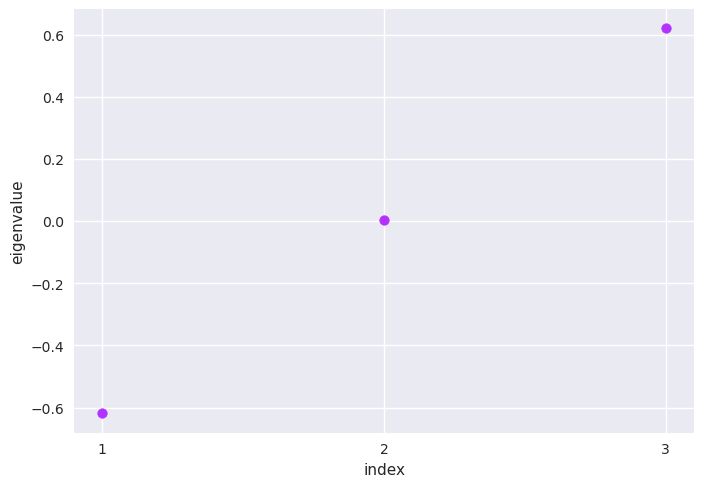

In [5]:
H.show_evs()

The above methods can be used to get a better understanding of you loss landscape. The hessian_scan method creates a collection of 1D scans, one of each Hessian eigenvalue. This is especially useful when trying to visualize slices that are not 1D or 2D themselves. It can also help you find interesting 2D subspaces to scan.

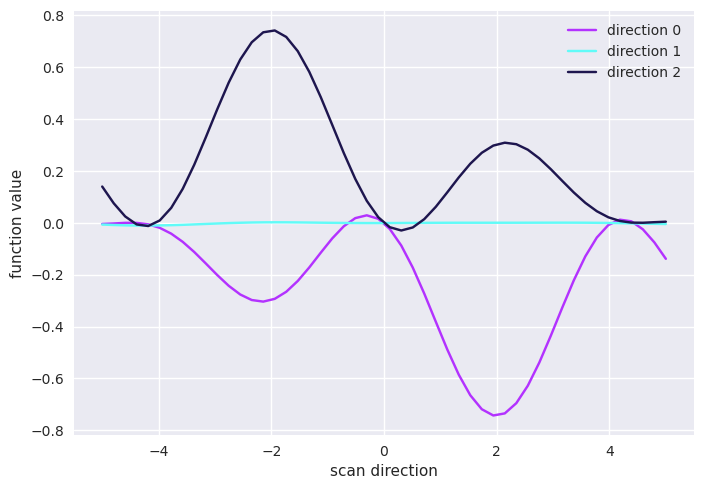

In [6]:
scan_H, H = hessian_scan(func=testfunc, subspace=subspace, resolution=50)
scan_H.show()
plt.legend()

If you had just scanned the subspace as is, you would have obtained the following plot:

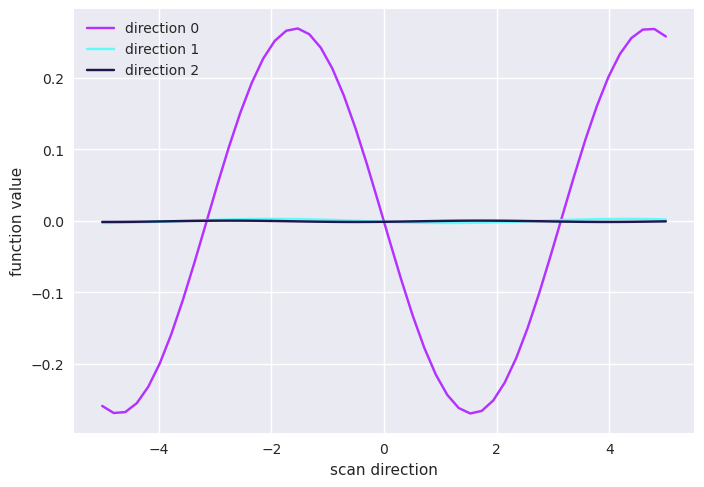

In [7]:
scan_noH = collective_scan_linear(
    func=testfunc, subspace=subspace, resolution=50
)
scan_noH.show()
plt.legend()

You can use the showlist argument to only show certain scans from the collection.
In combination with the Hessian eigenvalues, this can be used to exclude scan directions in which the landscape is relatively flat.

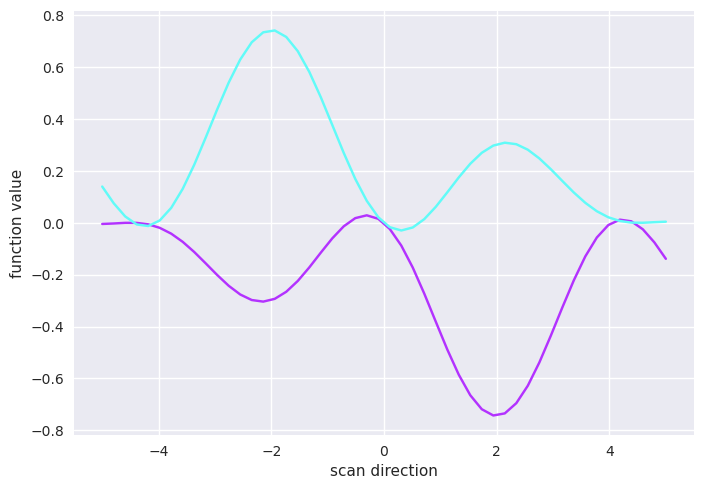

In [8]:
scan_H, H = hessian_scan(func=testfunc, subspace=subspace, resolution=50)
scan_H.show(showlist=np.nonzero(np.abs(H.eigenvalues) > 0.1)[0])
plt.legend()
ax = plt.gca()
ax.get_legend().remove()

And as mentioned before you can use the Hessian scan to inform a 2D scan. Here we scan along the first and last eigenvector of the Hessian, as these were the most interesting in the collective plot.

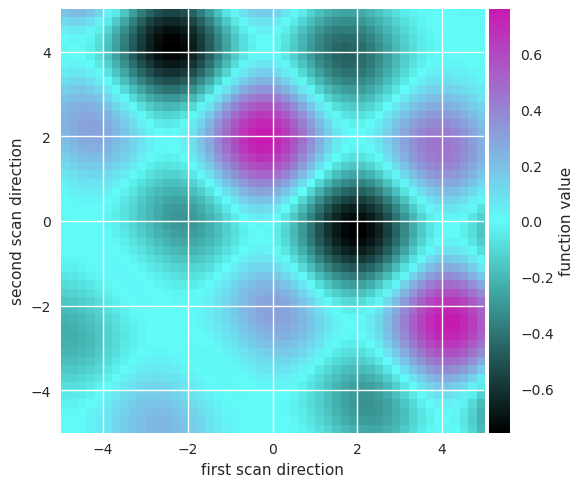

In [9]:
subspace6 = AffineSubspace(
    directions=np.concatenate(
        (
            scan_H.scanlist[0].subspace.directions,
            scan_H.scanlist[2].subspace.directions,
        ),
        axis=0,
    ),
    center=subspace.center,
)

scan6 = landscape_scan_linear(func=testfunc, subspace=subspace6, resolution=50)

scan6.show()

from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(cax=cax, label="function value")